# COMP90051 Workshop 2
## Bayesian inference

***

In this part of the workshop, we'll develop some intuition for priors and posteriors, which are crucial to Bayesian inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
from scipy.stats import bernoulli, beta

### 1. A lucky find

On the way to class, you discover an unusual coin on the ground.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/1_2_penny_Middlesex_DukeYork_1795_1ar85_%288737903267%29.jpg" alt="Coin" width="350"/>

As a dedicated student in statistical ML, you're interested in determining whether the coin is _biased_. 
More specifically, you want to estimate the probability $\theta$ that the coin will land heads-up when you toss it. If $\theta \approx \frac{1}{2}$ then we say that the coin is _unbiased_ (or fair).

You can use the function below to simulate a coin toss: it returns `1` for heads and `0` for tails.

In [2]:
def toss_coin():
    if bernoulli.rvs(p = (int.from_bytes("coin".encode(), 'little') % 10000)/10000):
        return 1
    return 0

### 2. Prior belief
Before you even toss the coin, you notice that the heads side appears to have more mass. 
Thus, your _prior belief_ is that $\theta$ is slightly biased away from $\frac{1}{2}$ towards 0—i.e. you expect tails are more likely.

To quantify this prior belief, we assume that the prior distribution for $\theta$ is $\mathrm{Beta}(a,b)$, for some choice of the hyperparameters $a, b > 0$. 
(See [link](https://en.wikipedia.org/wiki/Beta_distribution) for info about the Beta distribution.)
The prior probability density function for $\theta$ is therefore given by:

$$ p(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1 - \theta)^{b-1} $$

where $B(a,b)$ is a special function called the _Beta function_.

Select appropriate values for $a$ and $b$ by looking at the plot of $p(\theta)$ below.

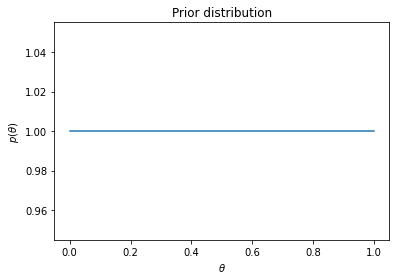

In [16]:
a = 1 # fill in
b = 1 # fill in
theta = np.linspace(0, 1, 1001)
plt.plot(theta, beta.pdf(theta, a, b))
plt.title('Prior distribution')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

### 3. Posterior updates
Now toss the coin once and denote the outcome by $x_1$.

In [18]:
x1 = toss_coin()
print(x1)

1


We can update our belief about $\theta$, based on this new evidence $x_1$.
To do this we apply Bayes' rule to compute the posterior for $\theta$:

$$ p(\theta | x_1) = \frac{p(x_1 | \theta) \, p(\theta)}{p(x_1)} \propto p(x_1 | \theta) \, p(\theta)$$

where $p(\theta)$ is the prior given above and 

$$ p(x_1 | \theta) = \theta^{x_1} (1 - \theta)^{1 - x_1} $$

is the likelihood.

***
**Exercise:** Show (on paper) that

$$ p(\theta | x_1) \propto \theta^{x_1 + a - 1} (1 - \theta)^{(1 - x_1) + b - 1} $$

which implies that $\theta | x_1 \sim \mathrm{Beta}[x_1 + a, (1 - x_1) + b]$.

_Hint: see Lecture 2, slide 24 (2c in the recording) for a similar calculation._
***

Toss the coin a second time, denoting the outcome by $x_2$.

In [19]:
x2 = toss_coin()
print(x2)

1


Again, we want to update our belief about $\theta$ based on the new information $x_2$. 
We take the previous posterior $p(\theta|x_1)$ as the new prior and apply Bayes' rule:

$$p(\theta | x_1, x_2) \propto p(x_2 | \theta) p(\theta | x_1)$$

\[Note: We assume the tosses are independent, otherwise the likelihood for $x_2$ would depend on $x_1$.\] 
This gives $\theta | x_1, x_2 \sim \mathrm{Beta}[x_1 + x_2 + a, (2 - x_1 - x_2) + b]$.

***
**Exercise:** Show that for $n$ coin tosses, the posterior is $\theta | x_1, \ldots, x_n \sim \operatorname{Beta}[n_H + a, n - n_H + b]$ where $n_H = \sum_{i = 1}^{n} x_i$ is the number of heads observed.
***

### 4. MAP estimator and MLE estimator

The posterior $\theta|x_1, \ldots, x_n$ contains all the information we know about $\theta$ after observing $n$ coin tosses.
One way of obtaining a point estimate of $\theta$ from the posterior, is to take the value with the maximum a posteriori probability (MAP):

$$
\begin{align}
    \hat{\theta}_\mathrm{MAP} &= \arg \max_{\theta} p(\theta|x_1, \ldots, x_n) \\
        & = \frac{n_H + a - 1}{n + a + b - 2}
\end{align}
$$

In general, the MAP estimator gives a different result to the maximum likelihood estimator (MLE) for $\theta$:

$$
\begin{align}
    \hat{\theta}_\mathrm{MLE} &=\arg \max_{\theta} p(x_1, \ldots, x_n|\theta) \\
        & = \frac{n_H}{n}
\end{align}
$$

***
**Exercise:** How would you derive the above results for $\hat{\theta}_\mathrm{MAP}$ and  $\hat{\theta}_\mathrm{MLE}$? Setup the equations necessary to solve for $\hat{\theta}_\mathrm{MAP}$ and  $\hat{\theta}_\mathrm{MLE}$. You do not need to solve the equations at this stage.

**Extension** (Only return to this if you have completed the remaining workshop): Solve the equations you derived above. Give the condition for the estimators to be (exactly) equal, i.e. $\hat{\theta}_\mathrm{MAP} \equiv \hat{\theta}_\mathrm{MLE}$. What is the prior in this case?
***

### 5. Convergence of the estimates

Let's now toss the coin an additional 48 times (so that $n = 50$), recording $\hat{\theta}_\mathrm{MLE}$ and $\hat{\theta}_\mathrm{MAP}$ after each toss.

In [24]:
extra_tosses = 48
num_tosses = 2 + extra_tosses
num_heads = 0
theta_map = np.zeros(num_tosses)
theta_mle = np.zeros(num_tosses)
for i in range(0, num_tosses):
    if i == 0: 
        num_heads += x1 
    elif i == 1:
        num_heads += x2
    else:
        num_heads += toss_coin()
    theta_map[i] = (num_heads + a - 1) / (i + 1 + a + b - 2) # fill in
    theta_mle[i] = num_heads / (i + 1) # fill in

We plot the results below.

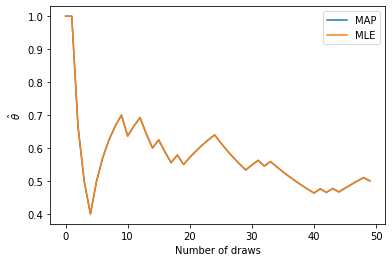

In [25]:
plt.plot(theta_map, label = "MAP")
plt.plot(theta_mle, label = "MLE")
plt.xlabel('Number of draws')
plt.ylabel(r'$\hat{\theta}$')
plt.legend()
plt.show()

**Questions:** 

1. Is the coin biased?
1. Do the MAP and MLE estimates converge to the same value for $\theta$?
1. What happens if you set $a = 1; b = 1$?
1. How does the posterior distribution for $\theta$ compare to the prior plotted above? (Use the code block below to plot the posterior.)

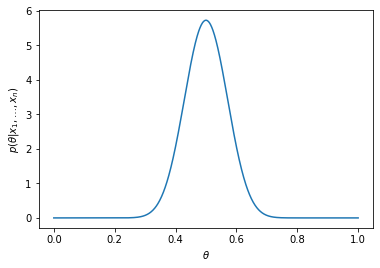

In [26]:
theta_dist = beta(a + num_heads, b + num_tosses - num_heads)
plt.plot(theta, theta_dist.pdf(theta))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|x_1, \ldots, x_n)$')
plt.show()

Finally, we'll visualize the evolution of the posterior distribution as we observe more data. Before running the code cell below, take a couple of minutes to discuss with those around you how you expect the posterior to behave qualitatively) as the number of observed samples $x_n$ increases.

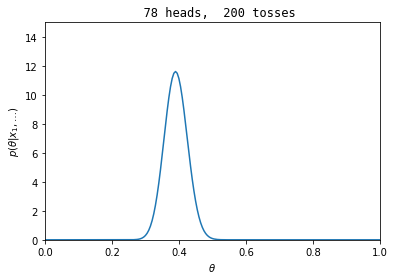

In [27]:
# Adapted from https://matplotlib.org/3.1.1/gallery/animation/bayes_update.html

class UpdateBetaBernoulli:
    def __init__(self, ax, a, b, theta_num_points = 201):
        self.a = a
        self.b = b
        self.ax = ax
        self.num_heads = 0
        self.num_tosses = 0
        self.theta = np.linspace(0, 1, theta_num_points)
        self.line, = ax.plot([], [])

    def reset(self):
        """Reset"""
        self.num_heads = 0
        self.num_tosses = 0
        self.line.set_data([], [])
        return self.line,

    def __call__(self, num_tosses):
        """Perform tosses and update plot"""
        for _ in range(num_tosses):
            self.num_tosses += 1
            self.num_heads += toss_coin()
        y = beta.pdf(self.theta, self.num_heads + self.a, self.num_tosses - self.num_heads + self.b)
        self.line.set_data(self.theta, y)
        self.ax.set_title('{:>4} heads, {:>4} tosses'.format(self.num_heads, self.num_tosses), family='monospace')
        return self.line, self.ax.title

# Set up figure
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 15)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta|x_1, \ldots)$')

ud = UpdateBetaBernoulli(ax, a, b)
FuncAnimation(fig, ud, frames=[1]*200, init_func=ud.reset, repeat=False, interval=50, blit=True)